# Исследование по метрикам на основе данных моего произношения

## Импорт библиотеки

In [2]:
# Для взаимодействия с системой
import sys
import os
import re
# Для работы с массивами чисел
import numpy as np 
# Для оценки качества распознавания речи
from jiwer import wer, cer, mer, wil
# Для вычисления расстояния Левенштейна
import Levenshtein
# Для статистического анализа данных
from scipy.stats import pearsonr, linregress
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk
# Для работы с базами данных PostgreSQL
import psycopg2
# Для работы с данными в формате DataFrame
import pandas as pd
# Для визуализации данных
import matplotlib.pyplot as plt
# Для работы со звуковыми файлами
import io
import soundfile as sf
import librosa
# Для обработки естественного языка
import nltk
import string
from nltk.stem import WordNetLemmatizer
# Для работы с различными сервисами распознавания речи
from AutomaticSpeechRecognitionYandex import AutomaticSpeechRecognitionYandex
from AutomaticSpeechRecognitionSaluteSpeech import AutomaticSpeechRecognitionSaluteSpeech
from AutomaticSpeechRecognitionMBART50 import AutomaticSpeechRecognitionMBART50

from tokens import FOLDER_ID, OAUTH, CLIENT_ID, CLIENT_SECRET

## Загрузка данных с БД

In [3]:
# Сбор список слов
from sentences_text import sentences_text

### Коллекция слов

In [4]:
for theme, words in sentences_text.items():
    print(f"Тема: {theme}")
    print("Предложение:", words)
    print("\n")

Тема: Искусственный интеллект
Предложение: Искусственный интеллект (ИИ) - это область компьютерных наук, создающая системы для выполнения задач, требующих человеческого интеллекта: распознавание речи, обработка изображений, принятие решений. Искусственный интеллект проникает во все сферы жизни, от рекомендаций в онлайн-магазинах до медицинских диагнозов.

Главное преимущество ИИ - способность обрабатывать большие объемы данных и выявлять закономерности. В медицине он помогает диагностировать заболевания, анализируя снимки и историю болезни. В бизнесе искусственный интеллект используется для прогнозирования рынка, оптимизации цепочек поставок и автоматизации процессов.

ИИ базируется на алгоритмах машинного обучения, позволяющих системам обучаться на основе данных. Современные ИИ-системы используют глубокие нейронные сети, имитирующие работу мозга. Для разработки таких моделей требуются мощные вычислительные ресурсы и инструменты, такие как TensorFlow и PyTorch.

Искусственный интеллект

## Анализ данных

In [72]:
df = pd.read_csv('database_preprocessing_metric.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_date                   461 non-null    object 
 1   id                            461 non-null    int64  
 2   topic                         461 non-null    object 
 3   paragraph_text                461 non-null    object 
 4   transcript_text_yandex        453 non-null    object 
 5   transcript_text_salutespeech  431 non-null    object 
 6   transcript_text_mbart50       461 non-null    object 
 7   voice_recording               461 non-null    object 
 8   lemmatized_text               461 non-null    object 
 9   WER_yandex                    453 non-null    float64
 10  CER_yandex                    453 non-null    float64
 11  MER_yandex                    453 non-null    float64
 12  WIL_yandex                    453 non-null    float64
 13  Leven

In [74]:
df.head()

,record_date,id,topic,paragraph_text,transcript_text_yandex,transcript_text_salutespeech,transcript_text_mbart50,voice_recording,lemmatized_text,WER_yandex,...,WER_salutespeech,CER_salutespeech,MER_salutespeech,WIL_salutespeech,Levenshtein_salutespeech,WER_mbart50,CER_mbart50,MER_mbart50,WIL_mbart50,Levenshtein_mbart50
0,2024-06-15,1,Искусственный интеллект,Искусственный интеллект (ИИ) - это область ком...,Искусственный интеллект это вопрос компьютерны...,NaN,"едивствительный характер, а то я, попросту, ко...",<memory at 0x7721cea20040>,искусственный интеллект ии это область компьют...,0.861,...,NaN,NaN,NaN,NaN,NaN,0.944,0.703,0.944,0.996,220.0
1,2024-06-15,2,Искусственный интеллект,Главное преимущество ИИ - способность обрабаты...,Структурный тракт Трапающий тракт Так из за по...,Осуществлённый тракт от оплаты компьютерных но...,"здесь копустимный тракт, а то просит купечески...",<memory at 0x7721cea201c0>,главное преимущество ии способность обрабатыва...,1.000,...,1.000,0.739,1.000,1.000,235.0,0.973,0.748,0.973,0.999,238.0
2,2024-06-15,4,Искусственный интеллект,ИИ базируется на алгоритмах машинного обучения...,Секс интеллект позируется на алгоритмах машина...,Интеллект позируется на алгоритмах машины появ...,"здесь к примеру интеллигент, пояснивая причину...",<memory at 0x7721cea20100>,ии базируется на алгоритмах машинного обучения...,0.889,...,0.806,0.566,0.806,0.938,168.0,0.917,0.694,0.868,0.975,206.0
3,2024-06-15,5,Искусственный интеллект,Искусственный интеллект - революционная технол...,Рвотчины технари мнящие мир и проносящие на че...,"Эффект революционный техногии, меняющий мир, п...","они киллект, революция, тихонги, мне очень яны...",<memory at 0x7721cea20580>,искусственный интеллект революционная технолог...,0.682,...,0.864,0.467,0.864,0.971,155.0,0.932,0.639,0.932,0.995,212.0
4,2024-06-16,6,Искусственный интеллект,Искусственный интеллект (ИИ) - это область ком...,Интеллект Видать трепающий челябинского интелл...,"Интеллект компьютерных наук, состоящих материа...","безопасный интеллект, дай-капитатурных наок, р...",<memory at 0x7721ceb625c0>,искусственный интеллект ии это область компьют...,0.833,...,0.778,0.355,0.778,0.934,111.0,1.000,0.652,1.000,1.000,204.0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   record_date                   461 non-null    object 
 1   id                            461 non-null    int64  
 2   topic                         461 non-null    object 
 3   paragraph_text                461 non-null    object 
 4   transcript_text_yandex        453 non-null    object 
 5   transcript_text_salutespeech  431 non-null    object 
 6   transcript_text_mbart50       461 non-null    object 
 7   voice_recording               461 non-null    object 
 8   lemmatized_text               461 non-null    object 
 9   WER_yandex                    453 non-null    float64
 10  CER_yandex                    453 non-null    float64
 11  MER_yandex                    453 non-null    float64
 12  WIL_yandex                    453 non-null    float64
 13  Leven

In [77]:
# Преобразуем значения в столбце 'record_date' в datetime.date
df['record_date'] = df['record_date'].apply(lambda x: pd.Timestamp(x).date())

In [78]:
# Задаем начальную и конечную даты для фильтрации
start_date = pd.Timestamp('2024-06-16').date()
end_date = pd.Timestamp('2024-08-20').date()

In [80]:
# Преобразуем индексы MultiIndex в датафрейме к типу datetime64 для временной фильтрации
df_filtered = df.loc[(df['record_date'] >= start_date) & (df['record_date'] <= end_date)]

In [82]:
# Сгруппируем по датам и ID
df_filtered = df_filtered.groupby(['record_date', 'id']).sum()

In [83]:
df_filtered.head()

topic  \
record_date id                            
2024-06-16  6   Искусственный интеллект   
            7   Искусственный интеллект   
            8   Искусственный интеллект   
            9                 Веб-сокет   
            10                Веб-сокет   

                                                   paragraph_text  \
record_date id                                                      
2024-06-16  6   Искусственный интеллект (ИИ) - это область ком...   
            7   Главное преимущество ИИ - способность обрабаты...   
            8   ИИ базируется на алгоритмах машинного обучения...   
            9   Веб-сокеты - это технология для обмена данными...   
            10  Главное преимущество веб-сокетов - поддержка п...   

                                           transcript_text_yandex  \
record_date id                                                      
2024-06-16  6   Интеллект Видать трепающий челябинского интелл...   
            7   Степощепанник обрабатывает пращи о примыканиях...   
            8   Исключительный интеллект революционные техноло...   
            9   Технология Мы не станем выраженным равномерным...   
            10  Го мне прымщ тебя высек эта поддержка штейна в...   

                                     transcript_text_salutespeech  \
record_date id                                                      
2024-06-16  6   Интеллект компьютерных наук, состоящих материа...   
            7                                                   0   
            8   Искусственный интеллект, революционные техноло...   
            9    В отличие от этой перезапросом и всякой обесп...   
            10  Да, мне пришло вот это поддержка почтенного св...   

                                          transcript_text_mbart50  \
record_date id                                                      
2024-06-16  6   безопасный интеллект, дай-капитатурных наок, р...   
            7   голубнеж тунеядцы, стипендиаты, стипендистки, ...   
            8   здесь к счастью, интеллигенты, ловящие на них ...   
            9   ибо, посяки эти, как ты нравы, мы не таны, мы ...   
            10  голубня, прыгнув тебе, джигурка, это поддержка...   

                           voice_recording  \
record_date id                               
2024-06-16  6   <memory at 0x7721ceb625c0>   
            7   <memory at 0x7721ceb63a00>   
            8   <memory at 0x7721ceb63c40>   
            9   <memory at 0x7721ceb63e80>   
            10  <memory at 0x7721ceb63b80>   

                                                  lemmatized_text  WER_yandex  \
record_date id                                                                  
2024-06-16  6   искусственный интеллект ии это область компьют...       0.833   
            7   главное преимущество ии способность обрабатыва...       0.811   
            8   ии базируется на алгоритмах машинного обучения...       1.250   
            9   вебсокеты это технология для обмена данными в ...       0.861   
            10  главное преимущество вебсокетов поддержка пост...       0.829   

                CER_yandex  MER_yandex  ...  WER_salutespeech  \
record_date id                          ...                     
2024-06-16  6        0.486       0.811  ...             0.778   
            7        0.491       0.811  ...             0.000   
            8        0.886       0.978  ...             1.000   
            9        0.639       0.861  ...             0.833   
            10       0.601       0.773  ...             0.610   

                CER_salutespeech  MER_salutespeech  WIL_salutespeech  \
record_date id                                                         
2024-06-16  6              0.355             0.778             0.934   
            7              0.000             0.000             0.000   
            8              0.774             1.000             1.000   
            9              0.544             0.833             0.957   
            10   

/tmp/ipykernel_98654/2220433589.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_metrics = daily_metrics.fillna(method='ffill')


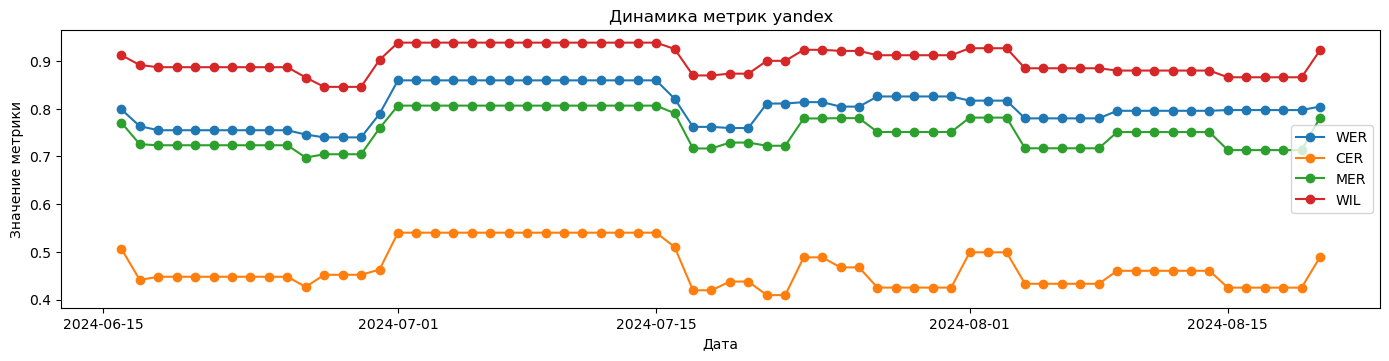

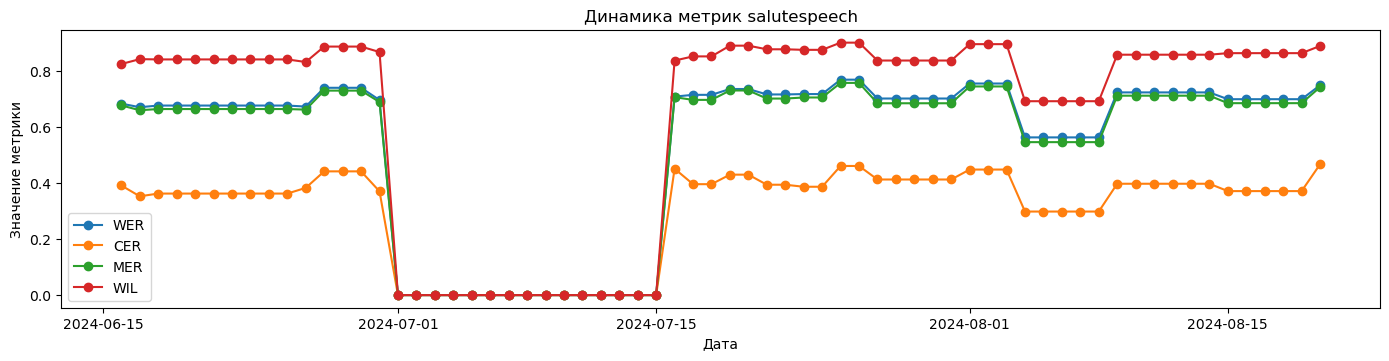

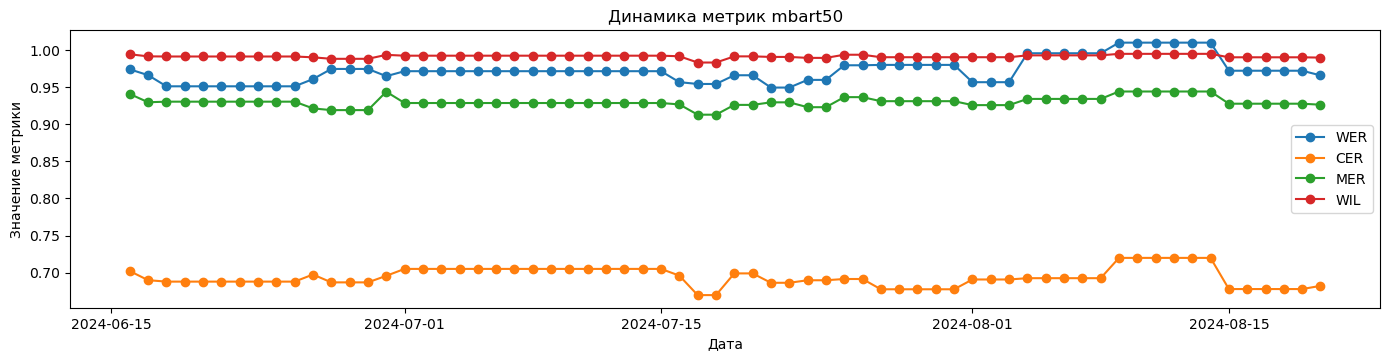

In [84]:
# Преобразуем первый уровень MultiIndex (даты) в DatetimeIndex
df_filtered.index = pd.to_datetime(df_filtered.index.get_level_values(0))

# Оставляем только числовые столбцы для группировки и агрегации
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64'])

# Устраняем дубликаты по дате, агрегируя их средним значением
df_filtered_numeric = numeric_columns.groupby(df_filtered.index).mean()

# Агрегируем метрики по дням, заполняя пропуски
daily_metrics = df_filtered_numeric.resample('D').asfreq()

# Заполняем пропуски методом ffill (линейно от предыдущих значений)
daily_metrics = daily_metrics.fillna(method='ffill')
# Заполняем пропуски нулями
# daily_metrics = daily_metrics.fillna(0)

# Функция для создания графика динамики по метрикам для одной модели
def plot_model_metrics(model_name):
    plt.figure(figsize=(14, 10))

    # WER, CER, MER, WIL, Levenshtein
    plt.subplot(3, 1, 1)
    plt.plot(daily_metrics.index, daily_metrics[f'WER_{model_name}'], label=f'WER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'CER_{model_name}'], label=f'CER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'MER_{model_name}'], label=f'MER', marker='o')
    plt.plot(daily_metrics.index, daily_metrics[f'WIL_{model_name}'], label=f'WIL', marker='o')
    # plt.plot(daily_metrics.index, daily_metrics[f'Levenshtein_{model_name}'], label=f'Levenshtein {model_name}', marker='o')
    plt.title(f'Динамика метрик {model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Построение графиков для каждой модели
models = ['yandex', 'salutespeech', 'mbart50']

for model in models:
    plot_model_metrics(model)

### Визуализация динамики метрик

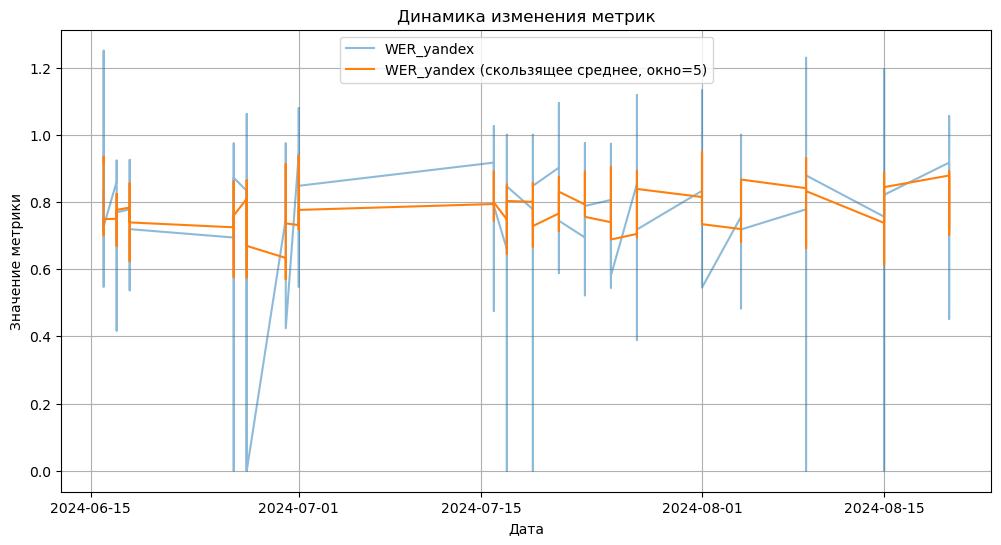

In [102]:
def plot_metrics(df, metrics, window=10): # Добавляем параметр window для размера окна
    df.index = pd.to_datetime(df.index.get_level_values(0))
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(df.index, df[metric], label=metric, alpha=0.5)  # Построение графика исходных данных
        plt.plot(df.index, df[metric].rolling(window=window).mean(), label=f'{metric} (скользящее среднее, окно={window})')  # Построение скользящего среднего
    plt.xlabel('Дата')
    plt.ylabel('Значение метрики')
    plt.title('Динамика изменения метрик')
    plt.legend()
    plt.grid(True)
    plt.show()

# Отображаем динамику по метрикам Yandex
# metrics = ['WER_yandex', 'CER_yandex', 'MER_yandex', 'WIL_yandex']
metrics = ['WER_yandex']
# metrics = ['CER_yandex']
start_date = pd.Timestamp('2024-06-15').date()
end_date = pd.Timestamp('2024-08-20').date()
# plot_metrics(df.loc[(df['record_date'] >= start_date) & (df['record_date'] <= end_date)], metrics, window=5)
plot_metrics(df_filtered, metrics, window=5)

## Математический анализ

In [99]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 457 entries, 2024-06-16 to 2024-08-20
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   topic                         457 non-null    object 
 1   paragraph_text                457 non-null    object 
 2   transcript_text_yandex        449 non-null    object 
 3   transcript_text_salutespeech  428 non-null    object 
 4   transcript_text_mbart50       457 non-null    object 
 5   voice_recording               457 non-null    object 
 6   lemmatized_text               457 non-null    object 
 7   WER_yandex                    449 non-null    float64
 8   CER_yandex                    449 non-null    float64
 9   MER_yandex                    449 non-null    float64
 10  WIL_yandex                    449 non-null    float64
 11  Levenshtein_yandex            449 non-null    float64
 12  WER_salutespeech              428 non-null   

In [111]:
metrics = ['WER_yandex', 'CER_yandex', 'MER_yandex', 'WIL_yandex']

### Корреляция Пирсона между временем и каждой метрикой

In [115]:
def pearson_analysis(df, metric):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    time_indices = np.arange(len(df))  # временной индекс
    corr, p_value = pearsonr(time_indices, df[metric].values)
    print(f"Корреляция Пирсона для {metric}: {corr:.5f}, p-value: {p_value:.5f}")
    # return corr, p_value

for metric in metrics:
    pearson_analysis(df_filtered, metric)

Корреляция Пирсона для WER_yandex: 0.08826, p-value: 0.05938
Корреляция Пирсона для CER_yandex: -0.00483, p-value: 0.91795
Корреляция Пирсона для MER_yandex: 0.05794, p-value: 0.21639
Корреляция Пирсона для WIL_yandex: 0.03534, p-value: 0.45106


### Линейная регрессия для выявления тренда

In [118]:
# 2. Линейная регрессия для выявления тренда
def linear_regression_analysis(df, metric):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    time_indices = np.arange(len(df))
    slope, intercept, r_value, p_value, std_err = linregress(time_indices, df[metric])
    print(f"Линейная регрессия для {metric}: наклон: {slope:.4f}, R^2: {r_value**2:.5f}, p-value: {p_value:.4f}")
    # return slope, intercept, r_value**2, p_value

for metric in metrics:
    linear_regression_analysis(df_filtered, metric)

Линейная регрессия для WER_yandex: наклон: 0.0001, R^2: 0.00779, p-value: 0.0594
Линейная регрессия для CER_yandex: наклон: -0.0000, R^2: 0.00002, p-value: 0.9180
Линейная регрессия для MER_yandex: наклон: 0.0001, R^2: 0.00336, p-value: 0.2164
Линейная регрессия для WIL_yandex: наклон: 0.0000, R^2: 0.00125, p-value: 0.4511


### Тест Манна-Кендалла для монотонной тенденции

In [119]:
def mann_kendall_test(df, metric):
    df = df.copy()
    # Заполняем пропуски значением 0
    df[metric] = df[metric].fillna(0)  
    
    result = mk.original_test(df[metric].values)
    print(f"Манн-Кендалл тест для {metric}: {result.trend}, p-value: {result.p:.4f}, z: {result.z:.4f}")
    # return result

# Пример для метрики WER_yandex
for metric in metrics:
    mann_kendall_test(df_filtered, metric)

Манн-Кендалл тест для WER_yandex: increasing, p-value: 0.0033, z: 2.9369
Манн-Кендалл тест для CER_yandex: no trend, p-value: 0.6604, z: 0.4393
Манн-Кендалл тест для MER_yandex: increasing, p-value: 0.0227, z: 2.2792
Манн-Кендалл тест для WIL_yandex: increasing, p-value: 0.0027, z: 2.9994


Давайте разберем результаты по каждому из статистических методов анализа.

### 1. **Корреляция Пирсона**
- **WER_yandex**: Корреляция составляет 0.088, что указывает на очень слабую положительную корреляцию между метрикой и временем. Однако p-value (0.059) близко к значимому уровню 0.05, что может свидетельствовать о том, что это корреляция может быть случайной.
- **CER_yandex**: Корреляция -0.0048, практически нулевая, и p-value очень высокое (0.918), что означает отсутствие линейной зависимости между временем и метрикой CER.
- **MER_yandex**: Корреляция 0.058, что также указывает на слабую положительную зависимость, но p-value (0.216) указывает на то, что это может быть случайной зависимостью.
- **WIL_yandex**: Корреляция 0.035, что также указывает на слабую зависимость, но с p-value (0.451), незначимую на уровне 0.05.

### 2. **Линейная регрессия**
- **WER_yandex**: Наклон очень маленький (0.0001), R^2 = 0.00779, что означает, что только 0.78% вариаций в данных объясняются временным фактором. p-value (0.0594) немного выше порогового значения 0.05, что указывает на то, что тренд незначим.
- **CER_yandex**: Наклон практически нулевой, R^2 также почти 0, что подтверждает отсутствие тренда, p-value (0.9180) подтверждает это.
- **MER_yandex**: Наклон чуть больше (0.0001), но R^2 = 0.00336, что означает, что только 0.34% вариаций объясняются временем, и p-value (0.2164) подтверждает отсутствие значимого тренда.
- **WIL_yandex**: Наклон минимальный (0.0000), R^2 также очень маленький (0.00125), что указывает на отсутствие тренда, а p-value (0.4511) это подтверждает.

### 3. **Тест Манна-Кендалла**
- **WER_yandex**: Тест показывает **восходящий тренд** с низким p-value (0.0033) и значимым z (2.9369), что указывает на значительное увеличение метрики во времени.
- **CER_yandex**: Тест не обнаружил тренда, p-value (0.6604) очень высокое, а z (0.4393) указывает на отсутствие значимых изменений.
- **MER_yandex**: Тест показывает **восходящий тренд** с p-value (0.0227) и z (2.2792), что также свидетельствует о значительном увеличении метрики.
- **WIL_yandex**: Тест также показывает **восходящий тренд** с p-value (0.0027) и z (2.9994), что указывает на значительное увеличение.

### Общий вывод:
- Корреляция Пирсона и линейная регрессия указывают на слабые или отсутствующие линейные зависимости метрик от времени.
- Однако тест Манна-Кендалла выявляет **восходящие тренды** для метрик `WER_yandex`, `MER_yandex` и `WIL_yandex`, что говорит о том, что эти метрики увеличиваются со временем, несмотря на то, что линейные методы анализа не обнаружили значительных трендов.
- Метрика `CER_yandex` не показывает ни линейных изменений, ни трендов.

Это говорит о том, что улучшений в метриках не наблюдается, а скорее некоторые из них (особенно `WER_yandex`, `MER_yandex`, `WIL_yandex`) демонстрируют ухудшение (увеличение ошибок) со временем.